# Importación de librerias

In [1]:
import gymnasium as gym
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import matplotlib.pyplot as plt
import cv2

# Definicion del modelo

In [2]:
# Modelo de red neuronal
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, initial_layer=128, medium_layer=128):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, initial_layer)
        self.fc2 = nn.Linear(medium_layer, medium_layer)
        self.fc3 = nn.Linear(medium_layer, output_dim)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

# DQN

In [3]:
class DQNAgent:
    def __init__(
        self,
        state_dim,
        action_dim,
        replay_size=10000,
        batch_size=64,
        gamma=0.99,
        epsilon=1.0,
        epsilon_decay=0.999,
        epsilon_min=0.01,
        discretization_bins=10,
        lr=1e-4,
        initial_layer=128,
        medium_layer=128,
    ):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.replay_buffer = deque(maxlen=replay_size)
        self.batch_size = batch_size
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.loss_history = []
        self.mae_history = []
        self.discretization_bins = discretization_bins
        self.initial_layer = initial_layer
        self.medium_layer = medium_layer

        # Redes Q y Target
        self.q_network = DQN(
            state_dim, action_dim, self.initial_layer, self.medium_layer
        ).float()
        self.target_network = DQN(
            state_dim, action_dim, self.initial_layer, self.medium_layer
        ).float()
        self.update_target_network()

        self.optimizer = optim.Adam(
            self.q_network.parameters(), lr=lr, weight_decay=1e-5
        )
        self.criterion = nn.SmoothL1Loss()

    def update_target_network(self):
        """Copiar los pesos de la red principal a la red target."""
        self.target_network.load_state_dict(self.q_network.state_dict())

    def select_action(self, state):
        """Selecciona una acción siguiendo la política \(\epsilon\)-greedy."""
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_dim - 1)  # Acción aleatoria
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        with torch.no_grad():
            q_values = self.q_network(state)
        return torch.argmax(q_values).item()  # Acción con el mayor valor Q

    def store_experience(self, state, action, reward, next_state, terminated):
        """Almacena la experiencia en el buffer de repetición."""
        self.replay_buffer.append((state, action, reward, next_state, terminated))

    def train(self):
        """Entrena la red Q utilizando un batch de experiencias."""
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states, terminateds = zip(*batch)

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.long)
        rewards = torch.tensor(rewards, dtype=torch.float32)
        next_states = torch.tensor(next_states, dtype=torch.float32)
        terminateds = torch.tensor(terminateds, dtype=torch.float32)

        # Q valores actuales y valores objetivos
        q_values = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze()
        with torch.no_grad():
            q_values_next = self.target_network(next_states).max(1)[0]
            targets = rewards + self.gamma * q_values_next * (1 - terminateds)

        loss = self.criterion(q_values, targets)

        # Optimización de la red
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.loss_history.append(loss.item())
        self.mae_history.append(torch.abs(q_values - targets).mean().item())

In [4]:
def discretize_state(state, pos_space, vel_space):
    """Discretiza el estado continuo en segmentos discretos."""
    position, velocity = state
    pos_idx = np.digitize(position, pos_space) - 1
    vel_idx = np.digitize(velocity, vel_space) - 1
    return (pos_idx, vel_idx)

# Definicion de la gráficas

In [5]:
def plot_scores(scores):
    plt.plot(scores)
    plt.title("Episodic Scores")
    plt.xlabel("Episodes")
    plt.ylabel("Score")
    plt.show()

def plot_loss(loss_history):
    plt.plot(loss_history)
    plt.title("Loss History")
    plt.xlabel("Episodes")
    plt.ylabel("Loss")
    plt.show()

def plot_mae(mae_history):
    plt.plot(mae_history)
    plt.title("Mean Absolute Error (MAE)")
    plt.xlabel("Episodes")
    plt.ylabel("MAE")
    plt.show()

In [6]:
from tqdm import tqdm 

# Entrenamiento

In [7]:
def train_dqn(
    env_name="MountainCar-v0",
    episodes=10,
    target_update=10,
    # video_filename="dqn_training_video.mp4",
    initial_layer=128,
    medium_layer=128,
):
    env = gym.make(env_name, render_mode="rgb_array")
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    # Divide position and velocity into segments
    pos_space = np.linspace(
        env.observation_space.low[0], env.observation_space.high[0], 20
    )  # Between -1.2 and 0.6
    vel_space = np.linspace(
        env.observation_space.low[1], env.observation_space.high[1], 20
    )  # Between -0.07 and 0.07

    agent = DQNAgent(
        state_dim, action_dim, initial_layer=initial_layer, medium_layer=medium_layer
    )
    scores = []

    env.reset()
    # sample_frame = env.render()[0]
    # height, width, channels = (
    #     sample_frame.shape
    #     if len(sample_frame.shape) == 3
    #     else (sample_frame.shape[0], sample_frame.shape[1], 1)
    # )

    # obj_video = cv2.VideoWriter_fourcc(*"mp4v")
    # out = cv2.VideoWriter(
    #     video_filename, obj_video, 30, (width, height), isColor=(channels == 3)
    # )

    for episode in tqdm(range(episodes)):
        state = env.reset()[0]  # Starting position, starting velocity always 0
        state_p = np.digitize(state[0], pos_space)
        state_v = np.digitize(state[1], vel_space)
        episode_score = 0
        
        while True:
            # discretized_state = agent.discretize_state(state, pos_space, vel_space)
            # state_tensor = np.array(discretized_state, dtype=np.float32)

            action = agent.select_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)

            next_state_p = np.digitize(next_state[0], pos_space)
            next_state_v = np.digitize(next_state[1], vel_space)

            episode_score += reward

            # # Recompensa informativa
            # goal_position = 0.5
            # reward += (next_state[0] - state[0]) * 10  # Recompensa por acercarse
            # reward += abs(next_state[1])  # Recompensa por velocidad

            # if next_state_p[0] >= goal_position:
            #     reward += 100  # Meta alcanzada
            # elif truncated:
            #     reward -= 10  # Penalización por tiempo agotado

            if terminated:
                if episode_score >= 200:
                    reward = 100  # Recompensa por alcanzar la meta
                else:
                    reward = -10  # Penalización si no alcanza la meta

            agent.store_experience(state, action, reward, next_state, terminated)
            agent.train()

            state = next_state
            state_p = next_state_p
            state_v = next_state_v

            # frame = env.render()[0]
            # frame_bgr = (
            #     cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            #     if len(frame.shape) == 3
            #     else cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
            # )
            # out.write(frame_bgr)

            if terminated or truncated:
                break

        agent.epsilon = max(agent.epsilon * agent.epsilon_decay, agent.epsilon_min)
        scores.append(episode_score)

        if episode % target_update == 0:
            agent.update_target_network()

        # print(
        #     f"Episode {episode}, Score: {episode_score}, Epsilon: {agent.epsilon:.2f}"
        # )

    # out.release()
    env.close()

    plot_scores(scores)
    plot_loss(agent.loss_history)
    plot_mae(agent.mae_history)

    return scores, agent.loss_history, agent.mae_history

  0%|          | 0/30 [00:00<?, ?it/s]C:\Users\camia\AppData\Local\Temp\ipykernel_19408\1443698216.py:70: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  states = torch.tensor(states, dtype=torch.float32)
100%|██████████| 30/30 [00:26<00:00,  1.15it/s]


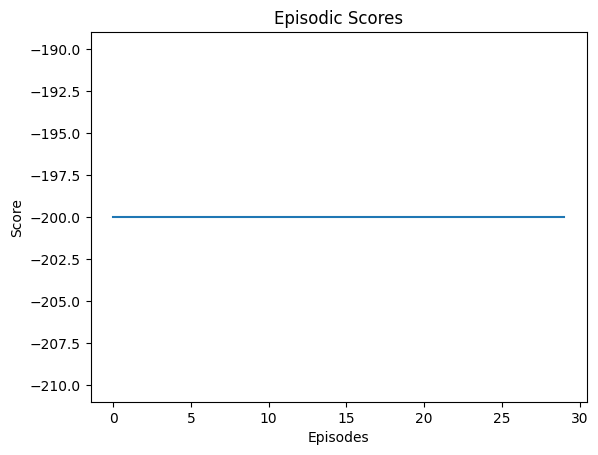

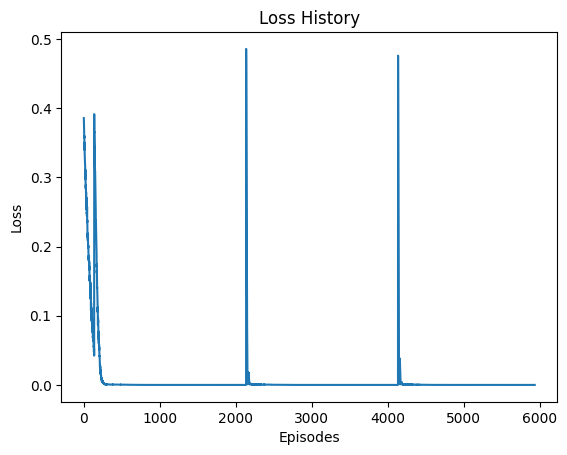

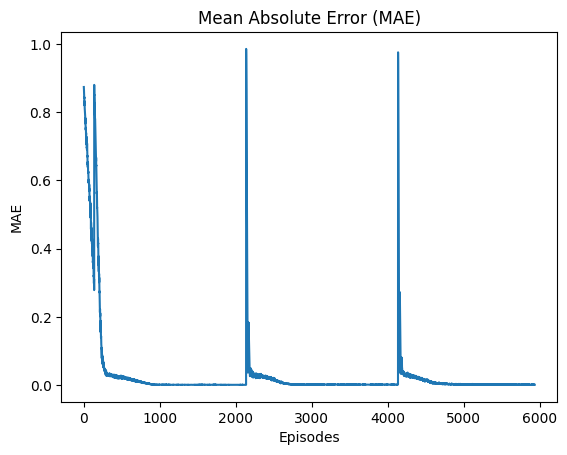

In [8]:
scores = train_dqn(episodes=30)